In [1]:
from matplotlib import pyplot
import cv2
import imagehash
import os

path = '/home/strider/Code/robotron/resources/images/'
spriteDefFile = open(path+'robotronsprites.txt', 'r')
spriteClasses = open(path+'robotronclasses.txt', 'r')
spriteSheet = cv2.imread(path+"robotronsprites.jpg")
ssh, ssw, _ = spriteSheet.shape
x = 0
y = 0

classes = {}
for line in spriteClasses:
    (name, classname) = line.split()
    classes[classname] = name
    
sprites = {}
spriteClasses = {}
rowheight = 0
i = 0
for line in spriteDefFile:
    i += 1
    (name, c, sid, w, h, _) = line.split()
    w = int(w) * 4
    h = int(h) * 2
    if x + w > ssw:
        x = 0
        y += rowheight + 10
        rowheight = 0
    sprite = spriteSheet[y:y+h, x:x+w]
    sprites[name] = sprite[:,:,::-1]
    spriteClasses[name] = c
    x += w + 10
    if h > rowheight:
        rowheight = h
        
X_test = []
X_name = []
for name in sprites.keys():
    sprite = sprites[name]
    cls = spriteClasses[name]
    if cls == '0':
        continue
    gray = cv2.cvtColor(sprite, cv2.COLOR_BGR2GRAY)
    X_test.append(gray)
    X_name.append(name)

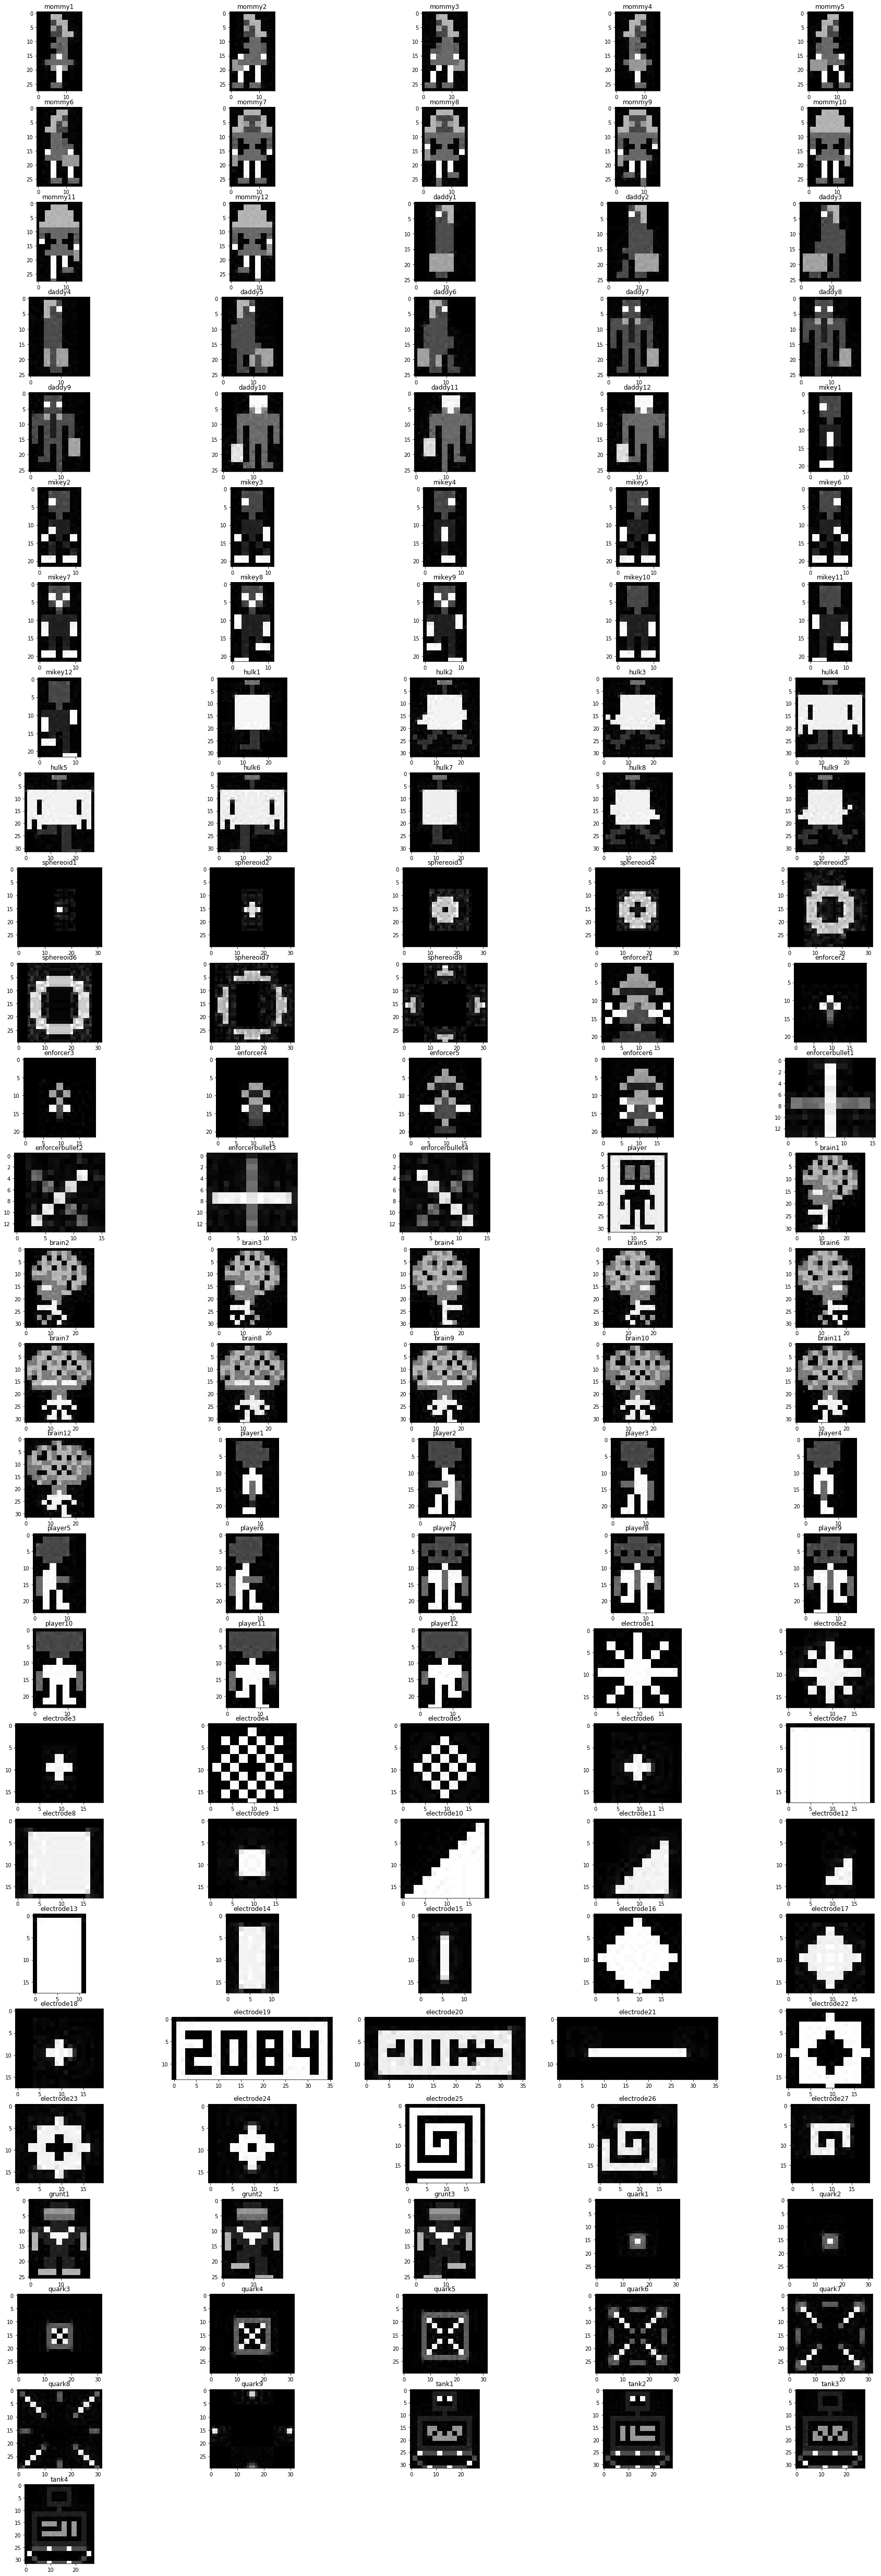

In [2]:
fig=pyplot.figure(figsize=(32, 90))
i = 0
r = 5
c = int(len(X_test) / r) + 1
for img, name in zip(X_test, X_name):
    i += 1
    subplot = fig.add_subplot(c, r, i)
    pyplot.imshow(img, cmap="gray")
    subplot.set_title(name)


In [32]:
from skimage.feature import local_binary_pattern
from skimage.segmentation import active_contour
# To calculate a normalized histogram 
from scipy.stats import itemfreq
from sklearn.preprocessing import normalize
import numpy as np
from moviepy.editor import VideoFileClip
import mahotas
import imutils
from scipy.spatial import distance as dist

In [50]:
#https://www.pyimagesearch.com/2014/05/19/building-pokedex-python-comparing-shape-descriptors-opencv/
def getMoments(img):
#     thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 7)
    ret,thresh = cv2.threshold(img,10,255,0)
    outline = np.zeros(img.shape, dtype = "uint8")
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    cv2.drawContours(outline, [cnts], -1, 255, -1)
    return mahotas.features.zernike_moments(outline, 16)
    
def match(img):
    sprite = getMoments(img)
    results = []
    for name, ref in zip(X_name, X_test):
        ref_sprite = getMoments(ref)
        score = dist.euclidean(sprite, ref_sprite)
        results.append((name, round(score, 3)))
    results = sorted(results, key=lambda score: score[1])
    return results

In [51]:
def process(frame):
    frame = cv2.resize(frame, (1280, 720))
    crop = frame[115:608, 309:975]
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray,10,255,0)
    blur = cv2.GaussianBlur(thresh, (3, 3), 0)
    contours, hierarchy = cv2.findContours(blur, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    fig=pyplot.figure(figsize=(32, 90))
    i = 0
    r = 10
    c = int(len(sprites) / 10) + 1
    for contour in enumerate(contours):       
        (x,y,w,h) = cv2.boundingRect(contour[1])
        if h < 10 or h > 415 or w < 5 or w > 145:
            continue
        sprite = gray[y:y+h, x:x+w]
        x += 309
        y += 115
        cv2.rectangle(frame, (x,y), (x+w,y+h), (255, 255, 255), 2)
        guess = match(sprite)
        print("{}\n".format(guess))
        i += 1
        subplot = fig.add_subplot(c, r, i)
        pyplot.imshow(sprite, cmap='gray')
        subplot.set_title("{}-{}".format(i, guess[0]))
        
        cv2.putText(frame, "Class: {}".format(guess[0]), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    return frame

[('brain8', 0.231), ('brain9', 0.231), ('brain10', 0.232), ('brain7', 0.236), ('brain11', 0.237), ('brain12', 0.242), ('tank2', 0.262), ('hulk4', 0.263), ('tank4', 0.263), ('tank1', 0.264), ('tank3', 0.264), ('hulk5', 0.273), ('hulk6', 0.273), ('player', 0.286), ('brain4', 0.296), ('brain3', 0.297), ('brain6', 0.297), ('brain1', 0.3), ('brain5', 0.3), ('hulk3', 0.301), ('brain2', 0.303), ('quark5', 0.311), ('sphereoid6', 0.323), ('electrode19', 0.328), ('hulk2', 0.331), ('electrode25', 0.335), ('hulk8', 0.337), ('hulk9', 0.337), ('grunt1', 0.356), ('grunt3', 0.361), ('electrode7', 0.365), ('grunt2', 0.371), ('hulk1', 0.403), ('hulk7', 0.403), ('mommy10', 0.421), ('electrode20', 0.423), ('mommy9', 0.435), ('mommy12', 0.437), ('mommy7', 0.438), ('mommy8', 0.438), ('daddy11', 0.445), ('mommy11', 0.451), ('daddy10', 0.46), ('daddy7', 0.463), ('daddy9', 0.474), ('daddy8', 0.48), ('player10', 0.484), ('sphereoid5', 0.485), ('player11', 0.495), ('daddy12', 0.5), ('enforcer1', 0.502), ('player

[('electrode21', 0.273), ('mikey4', 0.336), ('mikey1', 0.342), ('daddy1', 0.482), ('daddy4', 0.513), ('mommy4', 0.54), ('mikey2', 0.542), ('mikey12', 0.571), ('player4', 0.584), ('mikey3', 0.587), ('mikey6', 0.588), ('player1', 0.589), ('mikey5', 0.618), ('mommy1', 0.634), ('mikey8', 0.635), ('mikey11', 0.654), ('mikey7', 0.657), ('player3', 0.671), ('mikey10', 0.673), ('mikey9', 0.677), ('player2', 0.678), ('player6', 0.682), ('player5', 0.699), ('electrode14', 0.722), ('enforcer6', 0.732), ('electrode13', 0.745), ('enforcer5', 0.757), ('mommy6', 0.804), ('daddy2', 0.818), ('player12', 0.821), ('player8', 0.839), ('player11', 0.84), ('mommy2', 0.846), ('daddy3', 0.847), ('electrode10', 0.851), ('daddy5', 0.853), ('player9', 0.861), ('daddy6', 0.867), ('mommy3', 0.877), ('player10', 0.898), ('player7', 0.921), ('electrode26', 0.923), ('mommy5', 0.924), ('mommy9', 0.926), ('enforcer1', 0.929), ('daddy9', 0.942), ('electrode11', 0.946), ('daddy12', 0.956), ('mommy11', 0.959), ('daddy8', 

[('player', 0.156), ('tank2', 0.202), ('tank4', 0.205), ('tank1', 0.208), ('tank3', 0.208), ('hulk4', 0.222), ('hulk5', 0.25), ('hulk6', 0.25), ('brain9', 0.252), ('brain8', 0.255), ('brain12', 0.261), ('brain7', 0.262), ('brain11', 0.267), ('brain10', 0.274), ('electrode19', 0.303), ('brain5', 0.329), ('brain2', 0.357), ('brain6', 0.357), ('brain3', 0.358), ('brain4', 0.38), ('brain1', 0.383), ('hulk3', 0.39), ('hulk9', 0.426), ('hulk2', 0.43), ('hulk8', 0.438), ('electrode20', 0.462), ('grunt3', 0.485), ('sphereoid6', 0.495), ('grunt1', 0.507), ('grunt2', 0.509), ('electrode25', 0.529), ('mommy10', 0.54), ('daddy10', 0.544), ('daddy7', 0.548), ('daddy11', 0.55), ('mommy9', 0.555), ('mommy11', 0.557), ('player10', 0.558), ('hulk1', 0.563), ('hulk7', 0.563), ('mommy12', 0.567), ('mommy7', 0.568), ('mommy8', 0.569), ('quark5', 0.573), ('daddy8', 0.575), ('daddy9', 0.6), ('daddy12', 0.601), ('player11', 0.605), ('mommy5', 0.617), ('electrode7', 0.62), ('player7', 0.621), ('mommy2', 0.626

[('player', 0.133), ('tank4', 0.2), ('tank2', 0.201), ('tank1', 0.203), ('tank3', 0.203), ('hulk4', 0.209), ('hulk6', 0.238), ('hulk5', 0.239), ('brain9', 0.278), ('brain8', 0.281), ('brain7', 0.283), ('brain11', 0.289), ('brain12', 0.291), ('brain10', 0.299), ('electrode19', 0.31), ('brain5', 0.353), ('brain6', 0.37), ('brain3', 0.371), ('brain2', 0.374), ('brain4', 0.391), ('brain1', 0.395), ('hulk3', 0.397), ('hulk2', 0.434), ('hulk9', 0.434), ('hulk8', 0.442), ('electrode20', 0.45), ('sphereoid6', 0.454), ('grunt3', 0.488), ('grunt1', 0.505), ('grunt2', 0.509), ('electrode25', 0.52), ('quark5', 0.541), ('mommy10', 0.552), ('daddy10', 0.556), ('daddy7', 0.558), ('mommy9', 0.561), ('daddy11', 0.564), ('hulk1', 0.565), ('hulk7', 0.565), ('mommy11', 0.568), ('player10', 0.568), ('mommy12', 0.576), ('mommy7', 0.578), ('mommy8', 0.578), ('daddy8', 0.584), ('electrode7', 0.594), ('daddy9', 0.608), ('daddy12', 0.609), ('player11', 0.609), ('mommy5', 0.624), ('player7', 0.624), ('mommy2', 0

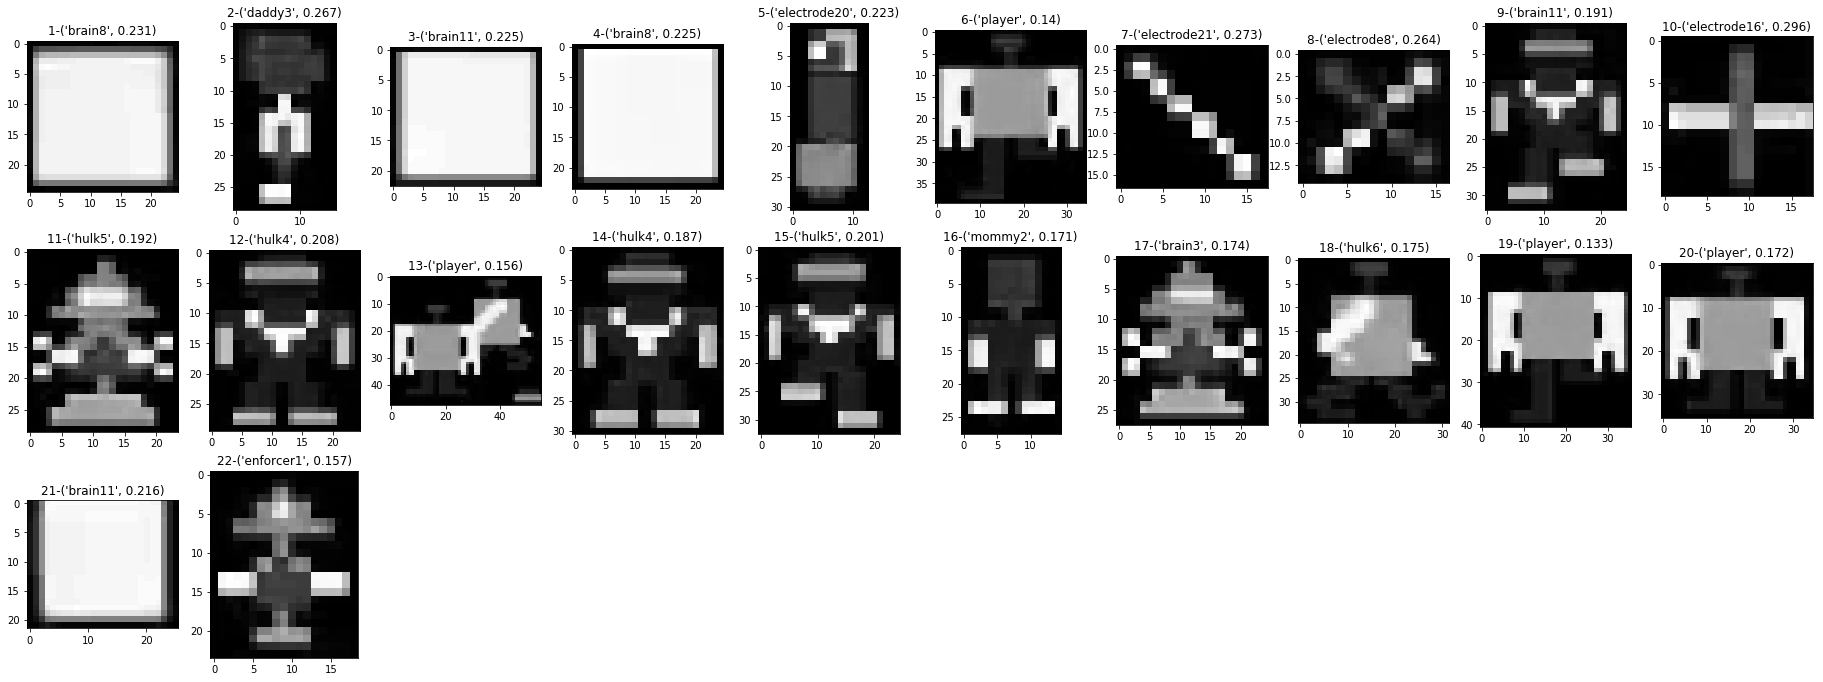

In [52]:
clip = VideoFileClip('/home/strider/Code/robotron/resources/video/robotron-1.mp4')
img = clip.get_frame(101.6)
pyplot.rcParams['figure.figsize'] = [24, 16]
im = process(img)

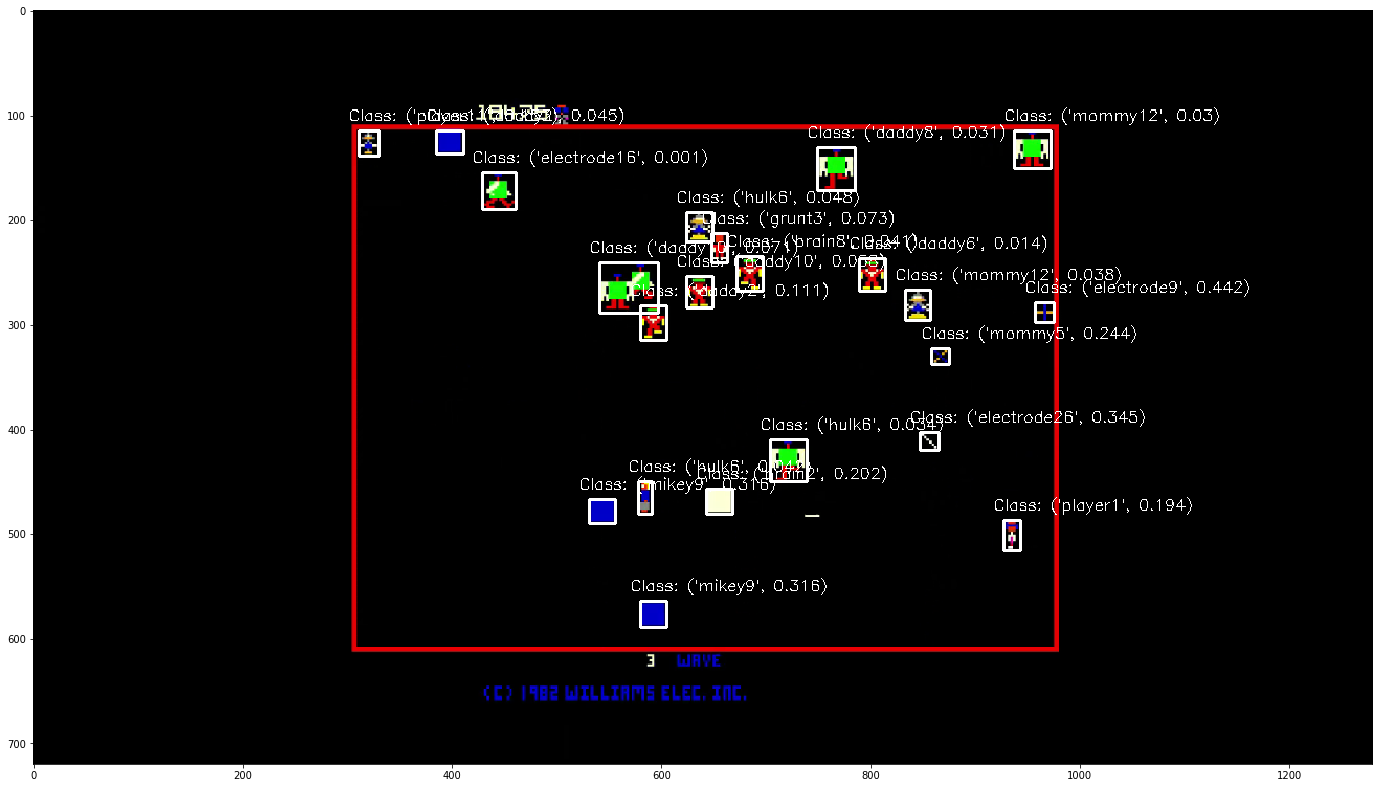

In [49]:
pyplot.imshow(im)